In [1]:
 !pip install deepcut

In [2]:
import deepcut
import pandas as pd
import numpy as np
from itertools import chain
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import joblib
import pickle

In [3]:
data = pd.read_excel("CPE_FAQ_Category.xlsx")
data

,CPE_questions,Category
0,วิศวะคอม/วิศวกรรมคอมพิวเตอร์ มีทั้งหมดกี่หลักส...,หลักสูตร
1,วิศวะคอม/วิศวกรรมคอมพิวเตอร์หลักสูตรนานาชาติปี...,หลักสูตร
2,วิศวะคอม/วิศวกรรมคอมพิวเตอร์หลักสูตรนานาชาติปี...,หลักสูตร
3,วิศวะคอม/วิศวกรรมคอมพิวเตอร์หลักสูตรนานาชาติ ป...,หลักสูตร
4,วิศวะคอม/วิศวกรรมคอมพิวเตอร์หลักสูตรนานาชาติปี...,หลักสูตร
...,...,...
172,การสมัครกู้ยืมเรียน ทำอย่างไร?,คำถามทั่วไป
173,ทุนของภาควิชามีอะไรบ้าง？,คำถามทั่วไป
174,ทุนเพชรพระจอมเกล้าภาควิชารับกี่คน？,คำถามทั่วไป
175,ทุนจ้างงานคืออะไร？,คำถามทั่วไป


In [4]:
from itertools import chain
def tokenize_text_list(ls):
    """Tokenize list of text"""
    return list(chain.from_iterable([deepcut.tokenize(ls)]))
tokenized_texts =data.CPE_questions	.map(tokenize_text_list)

In [5]:
tokenized_texts

0      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์,  , มี, ...
1      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
2      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
3      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
4      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
                             ...                        
172     [การ, สมัคร, กู้ยืม, เรียน,  , ทำ, อย่าง, ไร, ?]
173             [ทุน, ของ, ภาค, วิชา, มี, อะไร, บ้าง, ？]
174       [ทุน, เพชรพระจอมเกล้าภาค, วิชารับ, กี่, คน, ？]
175                       [ทุน, จ้าง, งาน, คือ, อะไร, ？]
176    [ถ้า, อยาก, ไป, เรียน, ต่อต่าง, และ, ขอ, ทุน, ...
Name: CPE_questions, Length: 177, dtype: object

In [6]:
tokenized_texts

#Save File
with open('token_text_category.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(tokenized_texts, filehandle)

In [7]:
def text_to_bow(tokenized_text, vocabulary_):
    n_doc = len(tokenized_text)
    values, row_indices, col_indices = [], [], []
    for r, tokens in enumerate(tokenized_text):
        feature = {}
        for token in tokens:
            word_index = vocabulary_.get(token)
            if word_index is not None:
                if word_index not in feature.keys():
                    feature[word_index] = 1
                else:
                    feature[word_index] += 1
        for c, v in feature.items():
            values.append(v)
            row_indices.append(r)
            col_indices.append(c)
        #print(feature)

    # document-term matrix in sparse CSR format
    X = sp.csr_matrix((values, (row_indices, col_indices)),
                      shape=(n_doc, len(vocabulary_)))
    return X

vocabulary_ = {v: k for k, v in enumerate(set(chain.from_iterable(tokenized_texts)))}
X = text_to_bow(tokenized_texts, vocabulary_)

In [8]:
X

<177x328 sparse matrix of type '<class 'numpy.intc'>'
	with 2334 stored elements in Compressed Sparse Row format>

In [9]:
transformer = TfidfTransformer()
svd_model = TruncatedSVD(n_components=100,
                         algorithm='arpack', n_iter=100)
X_tfidf = transformer.fit_transform(X)
X_svd = svd_model.fit_transform(X_tfidf)
y = pd.get_dummies(data.Category).values
X_train, X_test, y_train, y_test = train_test_split(X_svd, y, stratify=y)

In [10]:
y.shape

(177, 4)

# Logistic Model

In [22]:
logist_model = LogisticRegression()
cv_scores = []
for c in range(y.shape[1]):
    cv_scores.append(cross_val_score(logist_model, X_svd, y[:, c], cv=10, scoring='accuracy').mean())
tag = pd.get_dummies(data.Category).columns
logist_scores = list(zip(tag, cv_scores))
print(list(zip(tag, cv_scores)))

[('การรับเข้านักศึกษา', 0.8928104575163399), ('คำถามทั่วไป', 0.8251633986928104), ('ลงทะเบียนเรียน', 0.7967320261437909), ('หลักสูตร', 0.9202614379084967)]


In [12]:
logist_models = []
for c in range(y.shape[1]):
    logist_model = LogisticRegression()
    logist_model.fit(X_train, y_train[:, c])
    logist_models.append(logist_model)
#Save Model
joblib_file = "category_model.pkl"
joblib.dump(logist_models, joblib_file)

['category_model.pkl']

In [13]:
y_pred = np.argmax(np.vstack([model.predict_proba(X_svd)[:, 1] for model in logist_models]).T, axis=1)
y_pred = np.array([tag[yi] for yi in y_pred])
y_true = data.Category.values
C = confusion_matrix(y_true, y_pred) # confusion matrix
print(C)
print(tag[0:4])

[[11  1  1  6]
 [ 0 29  5  2]
 [ 0  0 37  2]
 [ 0  0  1 82]]
Index(['การรับเข้านักศึกษา', 'คำถามทั่วไป', 'ลงทะเบียนเรียน', 'หลักสูตร'], dtype='object')


In [14]:
logist_scores

[('การรับเข้านักศึกษา', 0.8928104575163399),
 ('คำถามทั่วไป', 0.8251633986928104),
 ('ลงทะเบียนเรียน', 0.7967320261437909),
 ('หลักสูตร', 0.9202614379084967)]

[Text(0, 0.5, 'การรับเข้านักศึกษา'),
 Text(0, 1.5, 'คำถามทั่วไป'),
 Text(0, 2.5, 'ลงทะเบียนเรียน'),
 Text(0, 3.5, 'หลักสูตร')]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3634 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3619 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3633 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3610 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3648 missing from current

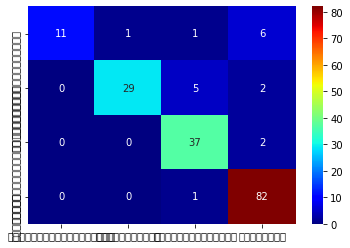

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
label = ['การรับเข้านักศึกษา' , 'คำถามทั่วไป' 
 , 'ลงทะเบียนเรียน'
 , 'หลักสูตร']
ax = sns.heatmap(C, annot= True, cmap='jet')
ax.set_xticklabels(label)
ax.set_yticklabels(label)

## Play Model

In [23]:
data = pd.read_excel("Category.xlsx")
data

,Category
0,หลักสูตร
1,คำถามทั่วไป
2,ลงทะเบียนเรียน
3,การรับเข้านักศึกษา


In [24]:
#Lib
import pickle
#Load File
with open('token_text_category.data', 'rb') as filehandle:
    # read the data as binary data stream
    tokenized_texts = pickle.load(filehandle)

In [17]:
tokenized_texts

0      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์,  , มี, ...
1      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
2      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
3      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
4      [วิศวะ, คอม, /, วิศวกรรม, คอมพิวเตอร์, หลักสูต...
                             ...                        
172     [การ, สมัคร, กู้ยืม, เรียน,  , ทำ, อย่าง, ไร, ?]
173             [ทุน, ของ, ภาค, วิชา, มี, อะไร, บ้าง, ？]
174       [ทุน, เพชรพระจอมเกล้าภาค, วิชารับ, กี่, คน, ？]
175                       [ทุน, จ้าง, งาน, คือ, อะไร, ？]
176    [ถ้า, อยาก, ไป, เรียน, ต่อต่าง, และ, ขอ, ทุน, ...
Name: CPE_questions, Length: 177, dtype: object

In [25]:
def text_to_bow(tokenized_text, vocabulary_):
    n_doc = len(tokenized_text)
    values, row_indices, col_indices = [], [], []
    for r, tokens in enumerate(tokenized_text):
        feature = {}
        for token in tokens:
            word_index = vocabulary_.get(token)
            if word_index is not None:
                if word_index not in feature.keys():
                    feature[word_index] = 1
                else:
                    feature[word_index] += 1
        for c, v in feature.items():
            values.append(v)
            row_indices.append(r)
            col_indices.append(c)
        #print(feature)

    # document-term matrix in sparse CSR format
    X = sp.csr_matrix((values, (row_indices, col_indices)),
                      shape=(n_doc, len(vocabulary_)))
    return X

vocabulary_ = {v: k for k, v in enumerate(set(chain.from_iterable(tokenized_texts)))}
X = text_to_bow(tokenized_texts, vocabulary_)

In [27]:
transformer = TfidfTransformer()
svd_model = TruncatedSVD(n_components=100,
                         algorithm='arpack', n_iter=100)
X_tfidf = transformer.fit_transform(X)
X_svd = svd_model.fit_transform(X_tfidf)

In [28]:
tag = pd.get_dummies(data.Category).columns

In [29]:
import joblib
#Load Model
logist_models = joblib.load("category_model.pkl")

In [30]:
logist_models

[LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression()]

In [35]:
y_pred = np.argmax(np.vstack([model.predict_proba(X_svd)[:, 1] for model in logist_models]).T, axis=1)
y_pred = np.array([tag[yi] for yi in y_pred])
y_true = data.Category.values
print(tag[0:4])

Index(['การรับเข้านักศึกษา', 'คำถามทั่วไป', 'ลงทะเบียนเรียน', 'หลักสูตร'], dtype='object')


In [32]:
text = 'วิศวคอมพิวเตอร์มีหลักสูตรอะไรบ้าง'
tokenized_text = deepcut.tokenize(text)
x = text_to_bow([tokenized_text], vocabulary_)
x_tfidf = transformer.transform(x)
x_svd = svd_model.transform(x_tfidf)
pred = [model.predict_proba(x_svd.reshape(-1, 1).T).ravel()[1] for model in logist_models]
print(list(zip(tag, pred)))
predict_category = max(list(zip(tag, pred)))

[('การรับเข้านักศึกษา', 0.1550136045403496), ('คำถามทั่วไป', 0.2321125640280181), ('ลงทะเบียนเรียน', 0.0801201977246547), ('หลักสูตร', 0.4839496158840346)]


In [33]:
type(pred[0])

numpy.float64

In [34]:
max_value = 0
max_category = ''
pred_results = list(zip(tag, pred))
for pred_result in pred_results:
  # print(pred_result)
  if pred_result[1] > max_value:
    max_value = pred_result[1]
    max_category = pred_result[0]
print(max_category, max_value)

หลักสูตร 0.4839496158840346
